# Regression Modeling

This notebook explores different regression models to find the model that predicts future dengue fever outbreaks based on environmental variables such as humidity, precipitation and temperature the best using mean absolute error as the metric to be minimized.

## Imports

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
import time

from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

#Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost

## Functions

In [4]:
def reg_metrics(y_train, y_train_pred, y_test, y_test_pred, model='model'):
    '''Creates a table showing the mean absolute error of a model's predictions on the testing and training data'''
    test_mae = metrics.mean_absolute_error(y_test, y_test_pred, multioutput='raw_values')
    train_mae = metrics.mean_absolute_error(y_train, y_train_pred, multioutput='raw_values')
    metrics_df = pd.DataFrame(data = zip(test_mae, train_mae),
                              columns=['test_mae','train_mae'])
    metrics_df.index.names = [model]
    return metrics_df

In [157]:
def peak_boost(preds, scalar, mixed=None):
    '''A function to boost peaks of the predictions'''
    #Take derivative of predictions
    deriv = np.gradient(preds)
    #Scale derivative
    new_deriv = deriv * scalar
    #Integrate the new derivative starting from 0
    integral = cumtrapz(new_deriv, initial=0)
    length = range(len(preds))
    #Add intercept to match initial range
    boosted = [x+preds[0] for x in integral]
    
    #Option ways to put floors on the output, preventing negative case counts
    if mixed == 'max':
        out = [max(boosted[i], preds[i]) for i in length]
    elif mixed == 'pos':
        out = [max(boosted[i], 0) for i in length]
    else:
        out = boosted
    
    #Doubling values above a 0.992 threshold in order to better estimate peak cases.
    Ser = pd.Series(out)
    
    quantile_value = Ser.quantile(q=0.99)
    print(f'Values are doubled over this threshold: {quantile_value}')
    
    for k,v in Ser.items():
        if (v > quantile_value):
            Ser[k] = int(Ser[k]*2)
    
    return np.array([int(x) for x in Ser])

## Loading data

In [12]:
#Importing training data and merging features and target
data = pd.read_csv('../raw_data/dengue_features_train.csv')
labels = pd.read_csv('../raw_data/dengue_labels_train.csv')
data = data.merge(labels)
print(data.shape)

(1456, 25)


In [11]:
#Splitting data for each city (San Juan, Puerto Rico & Iquitos, Peru)
data_sj = data.iloc[:936,:]
data_iq = data.iloc[936:,:]

## Preprocessing

In [13]:
def preprocess(data,train=True):
    
    #Reset index to prevent issues when merging
    reindexed_data = data.reset_index(drop = True)
    
    #Fill nas with interpolation
    features = reindexed_data.interpolate(method='linear')
    
    new_columns = pd.DataFrame()
    #Scale and average total precipitation features
    precipitation_to_avg = features.loc[:,['reanalysis_sat_precip_amt_mm','precipitation_amt_mm','station_precip_mm','reanalysis_precip_amt_kg_per_m2']]
    scaled_precip = pd.DataFrame(MinMaxScaler().fit_transform(precipitation_to_avg), 
                                columns=precipitation_to_avg.columns)
    new_columns.loc[:,'avg_total_precipitation'] = scaled_precip.mean(axis=1)
    
    #Scale and average temperature features
    temps_to_avg = features.loc[:,['reanalysis_air_temp_k','reanalysis_avg_temp_k','station_avg_temp_c']]
    scaled_temps = pd.DataFrame(MinMaxScaler().fit_transform(temps_to_avg), 
                                columns=temps_to_avg.columns)
    new_columns.loc[:,'avg_temp'] = scaled_temps.mean(axis=1)
    
    #Scale and average max temperature features
    max_temps_to_avg = features.loc[:,['station_max_temp_c','reanalysis_max_air_temp_k']]
    scaled_max_temps = pd.DataFrame(MinMaxScaler().fit_transform(max_temps_to_avg), 
                                columns=max_temps_to_avg.columns)
    new_columns.loc[:,'avg_max_temp'] = scaled_max_temps.mean(axis=1)
    
    #Scale and average min temperature features
    min_temps_to_avg = features.loc[:,['station_min_temp_c','reanalysis_min_air_temp_k']]
    scaled_min_temps = pd.DataFrame(MinMaxScaler().fit_transform(min_temps_to_avg), 
                                columns=min_temps_to_avg.columns)
    new_columns.loc[:,'avg_min_temp'] = scaled_min_temps.mean(axis=1)
    
    #Scale and average diurnal temperature features
    diurnal_temps_to_avg = features.loc[:,['station_diur_temp_rng_c','reanalysis_tdtr_k']]
    scaled_diurnal_temps = pd.DataFrame(MinMaxScaler().fit_transform(diurnal_temps_to_avg), 
                                columns=diurnal_temps_to_avg.columns)
    new_columns.loc[:,'avg_diurnal_temp'] = scaled_diurnal_temps.mean(axis=1)
    
    #Scale humidity and dew point features
    remaining_feats_to_scale = features.loc[:,['reanalysis_specific_humidity_g_per_kg','reanalysis_relative_humidity_percent','reanalysis_dew_point_temp_k']]
    scaled_feats = pd.DataFrame(MinMaxScaler().fit_transform(remaining_feats_to_scale), 
                                columns=remaining_feats_to_scale.columns)
    
    df = new_columns.join(scaled_feats)
    
    #Add lagged features for 4 weeks
    to_shift = ['avg_max_temp','reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg','avg_total_precipitation','reanalysis_dew_point_temp_k','avg_min_temp'] 
    for i in to_shift:
        df[i+'_1lag'] = df[i].shift(-1)
        df[i+'_2lag'] = df[i].shift(-2)
        df[i+'_3lag'] = df[i].shift(-3)
        df[i+'_4lag'] = df[i].shift(-4)
    df = df.fillna(method='ffill')
    
    #Merge together

    if train:
        non_scaled_feats = features[['ndvi_ne', 'ndvi_nw',
           'ndvi_se', 'ndvi_sw','total_cases']]
    
    else:
        non_scaled_feats = features[['ndvi_ne', 'ndvi_nw',
           'ndvi_se', 'ndvi_sw']]
    
    final_df = df.join(non_scaled_feats)
    
    return final_df

In [14]:
iq_data = preprocess(data_iq)
sj_data = preprocess(data_sj)

In [15]:
print(iq_data.shape,sj_data.shape)

(520, 37) (936, 37)


## Baseline score 

For a baseline score we will look at the mean absolute error of the mean weekly dengue fever cases for both cities. This will give us a sense of how our models compare.

In [263]:
#Baseline mae to beat for San Juan
sj_baseline = abs(data_sj['total_cases']-(data_sj['total_cases'].mean())).mean()
sj_baseline

28.352089268755936

In [264]:
#Baseline mae to beat for Iquitos
iq_baseline = abs(data_iq['total_cases']-(data_iq['total_cases'].mean())).mean()
iq_baseline

6.684008875739645

In [266]:
#Combined mae to beat
iq_baseline + sj_baseline

35.03609814449558

## Modelling

### Splitting data

In [42]:
iq_X = iq_data.drop(['total_cases'], axis=1)
iq_y = iq_data.total_cases

iq_X_train = iq_X.head(390)
iq_X_test = iq_X.tail(130)
iq_y_train = iq_y.head(390)
iq_y_test = iq_y.tail(130)

print(iq_X_train.shape)
print(iq_X_test.shape)

(390, 36)
(130, 36)


In [43]:
sj_X = sj_data.drop(['total_cases'], axis=1)
sj_y = sj_data.total_cases

sj_X_train = sj_X.head(702)
sj_X_test = sj_X.tail(234)
sj_y_train = sj_y.head(702)
sj_y_test = sj_y.tail(234)

print(sj_X_train.shape)
print(sj_X_test.shape)

(702, 36)
(234, 36)


### KNN

In [44]:
#Define the parameters we want to use for the Grid Search
knn_params = {
    'n_neighbors': [3,5,11,15,18,21],
    'weights': ['uniform','distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [25,30,35],
    'p': [1,2]
}

In [45]:
# #Grid Search SJ
# start = time.time()

# knn = KNeighborsRegressor()
# search_knn = GridSearchCV(knn, param_grid=knn_params, 
#                               cv=TimeSeriesSplit(n_splits=5), n_jobs=-1, verbose=1, scoring='neg_mean_absolute_error')
# search_knn.fit(sj_X, sj_y);
# sj_knn_params = search_knn.best_params_
# print(search_knn.best_score_)

# executionTime = (time.time() - start)
# print("Execution time:",
#       np.round(executionTime,2)," seconds")

In [46]:
# #Grid Search IQ
# start = time.time()

# knn = KNeighborsRegressor()
# search_knn = GridSearchCV(knn, param_grid=knn_params, 
#                               cv=TimeSeriesSplit(n_splits=5), n_jobs=-1, verbose=1, scoring='neg_mean_absolute_error')
# search_knn.fit(iq_X, iq_y);
# iq_knn_params = search_knn.best_params_
# print(search_knn.best_score_)

# executionTime = (time.time() - start)
# print("Execution time:",
#       np.round(executionTime,2)," seconds")

In [47]:
#Storing results from Grid Search
sj_knn_params = {'algorithm': 'auto',
 'leaf_size': 25,
 'n_neighbors': 18,
 'p': 2,
 'weights': 'distance'}

iq_knn_params = {'algorithm': 'auto',
 'leaf_size': 25,
 'n_neighbors': 21,
 'p': 1,
 'weights': 'uniform'}

In [59]:
#Initialize models
sj_knn_model = KNeighborsRegressor(**sj_knn_params)
iq_knn_model = KNeighborsRegressor(**iq_knn_params)

#Fitting models on training data
sj_knn_model.fit(sj_X_train, sj_y_train)
iq_knn_model.fit(iq_X_train, iq_y_train)

print('Training Complete!')

#Predictions on training and testing data for San Juan
sj_train_pred = sj_knn_model.predict(sj_X_train).astype(int)
sj_test_pred = sj_knn_model.predict(sj_X_test).astype(int) 

#Predictions on training and testing data for Iquitos
iq_test_pred = iq_knn_model.predict(iq_X_test).astype(int)
iq_train_pred = iq_knn_model.predict(iq_X_train).astype(int)

Training Complete!


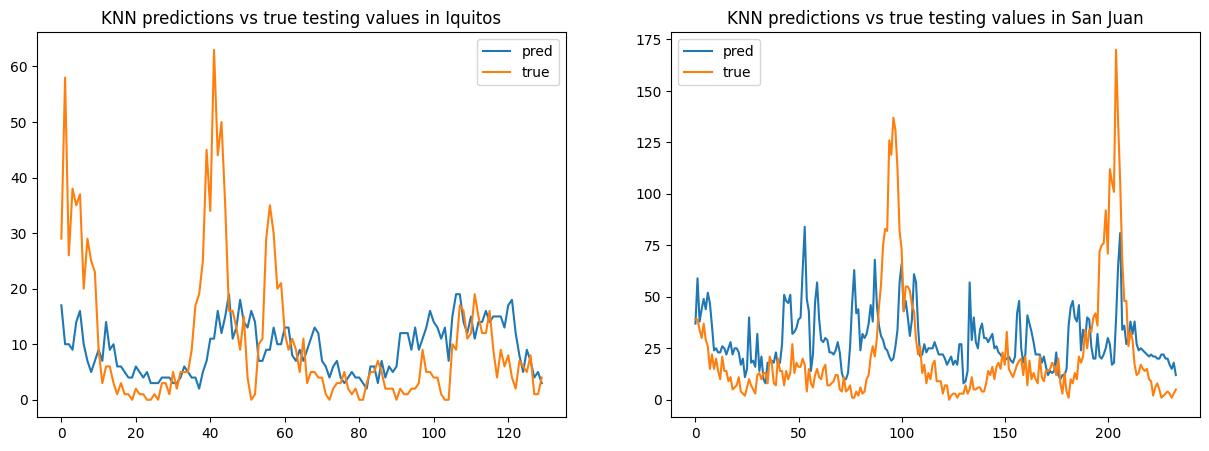

In [60]:
#Plotting true values vs predictions on testing data
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_test_pred, label='pred')
plt.plot(iq_y_test.values, label='true')
plt.legend()
plt.title('KNN predictions vs true testing values in Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_test_pred, label='pred')
plt.plot(sj_y_test.values, label='true')
plt.legend()
plt.title('KNN predictions vs true testing values in San Juan')
plt.show;

In [62]:
#Concatenating training and testing predictions and values for visualizations
iq_total_pred = np.hstack((iq_train_pred,iq_test_pred))
iq_true_values = np.hstack((iq_y_train.values,iq_y_test.values))

sj_total_pred = np.hstack((sj_train_pred,sj_test_pred))
sj_true_values = np.hstack((sj_y_train.values,sj_y_test.values))

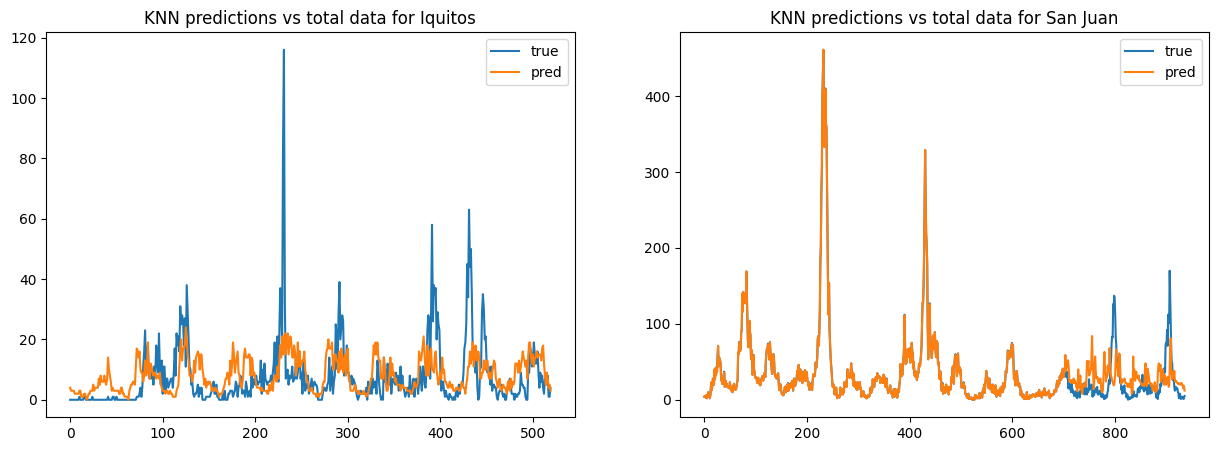

In [63]:
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_true_values, label='true')
plt.plot(iq_total_pred, label='pred')
plt.legend()
plt.title('KNN predictions vs total data for Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_true_values, label='true')
plt.plot(sj_total_pred, label='pred')
plt.legend()
plt.title('KNN predictions vs total data for San Juan')
plt.show;

In [64]:
# Get training and testing metrics to check for overfitting
sj_knn_metrics = reg_metrics(sj_y_train, sj_train_pred, sj_y_test, sj_test_pred,'San Juan KNN')
iq_knn_metrics = reg_metrics(iq_y_train, iq_train_pred, iq_y_test, iq_test_pred,'Iquitos KNN')

sj_knn_metrics, iq_knn_metrics

(               test_mae  train_mae
 San Juan KNN                      
 0             20.858974   0.096866,
              test_mae  train_mae
 Iquitos KNN                     
 0            8.023077   5.774359)

As can be seen in the metrics and visually on the graphs, the KNN model is overfitting for San Juan and is not able to detect patterns on unseen data. The KNN model is able to identify the trends on unseen data for Iquitos but not the large spikes, this is where our peak boosting function comes in to play.

In [71]:
#Using the peak boosting function to scale the predictions
print('San Juan:')
sj_boost = peak_boost(sj_total_pred, 1.5,'pos')
print('Iquitos:')
iq_boost = peak_boost(iq_total_pred, 1.5, 'max')

San Juan:
Values are doubled over this threshold: 517.4049999999997
Iquitos:
Values are doubled over this threshold: 27.510999999999967


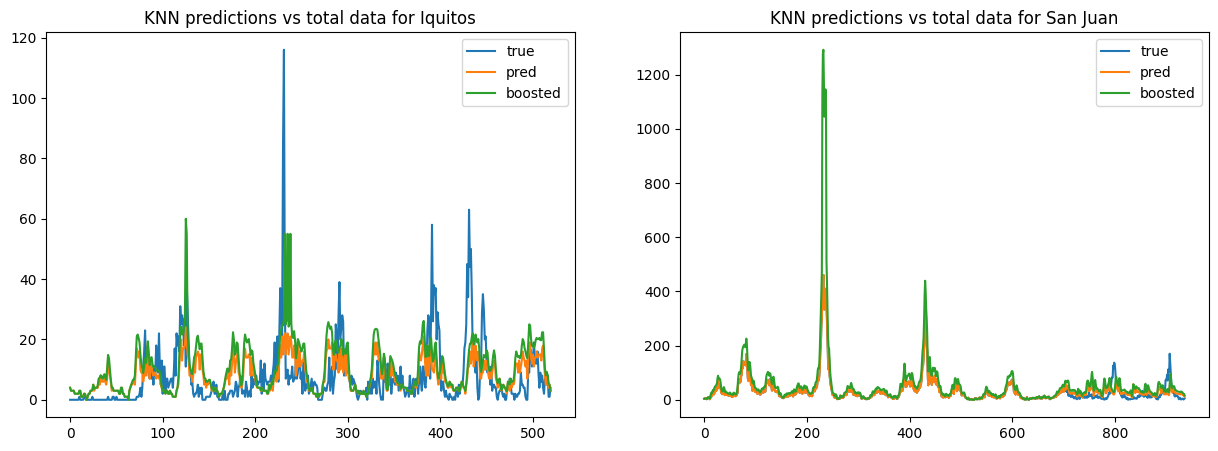

In [72]:
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_true_values, label='true')
plt.plot(iq_total_pred, label='pred')
plt.plot(iq_boost, label='boosted')
plt.legend()
plt.title('KNN predictions vs total data for Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_true_values, label='true')
plt.plot(sj_total_pred, label='pred')
plt.plot(sj_boost, label='boosted')
plt.legend()
plt.title('KNN predictions vs total data for San Juan')
plt.show;

In [73]:
sj_train_boost = peak_boost(sj_train_pred, 1.5, 'pos')
sj_test_boost = peak_boost(sj_test_pred, 1.5, 'pos')
iq_train_boost = peak_boost(iq_train_pred, 1.5, 'max')
iq_test_boost = peak_boost(iq_test_pred, 1.5, 'max')

Values are doubled over this threshold: 547.5999999999989
Values are doubled over this threshold: 75.81099999999998
Values are doubled over this threshold: 27.625
Values are doubled over this threshold: 19.0


In [74]:
# Get metrics after boosting
sj_knn_metrics = reg_metrics(sj_y_train, sj_train_boost, sj_y_test, sj_test_boost,'San Juan KNN')
iq_knn_metrics = reg_metrics(iq_y_train, iq_train_boost, iq_y_test, iq_test_boost,'Iquitos KNN')

sj_knn_metrics, iq_knn_metrics

(               test_mae  train_mae
 San Juan KNN                      
 0             19.706197  22.084758,
              test_mae  train_mae
 Iquitos KNN                     
 0            8.020192   6.898397)

### Support Vector Regressor

In [216]:
#Define the parameters for the Grid Search
svr_params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale','auto'],
    'C':[0.1, 1, 2]
}

In [217]:
# #Grid Search SJ
# start = time.time()

# svr = SVR()
# search_svr = GridSearchCV(svr, param_grid=svr_params, 
#                               cv=TimeSeriesSplit(n_splits=5), n_jobs=-1, verbose=1, scoring='neg_mean_absolute_error')
# search_svr.fit(sj_X, sj_y);
# sj_svr_params = search_svr.best_params_
# print(f'MAE: {abs(search_svr.best_score_)}')

# executionTime = (time.time() - start)
# print("Execution time:",
#       np.round(executionTime,2)," seconds")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAE: 24.520754435999713
Execution time: 5.52  seconds


In [219]:
# #Grid Search IQ
# start = time.time()

# svr = SVR()
# search_svr = GridSearchCV(svr, param_grid=svr_params, 
#                               cv=TimeSeriesSplit(n_splits=5), n_jobs=-1, verbose=1, scoring='neg_mean_absolute_error')
# search_svr.fit(iq_X, iq_y);
# iq_svr_params = search_svr.best_params_
# print(f'MAE: {abs(search_svr.best_score_)}')

# executionTime = (time.time() - start)
# print("Execution time:",
#       np.round(executionTime,2)," seconds")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAE: 6.609662649169087
Execution time: 0.84  seconds


In [221]:
#Storing results from Grid Search
sj_svr_params = {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
iq_svr_params = {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}

In [222]:
#Initialize models
sj_svr_model = SVR(**sj_svr_params)
iq_svr_model = SVR(**iq_svr_params)

#Fitting models on training data
sj_svr_model.fit(sj_X_train, sj_y_train)
iq_svr_model.fit(iq_X_train, iq_y_train)
print('Training Complete!')

#Making predictions on training and testing data for San Juan
sj_train_pred = sj_svr_model.predict(sj_X_train).astype(int)
sj_test_pred = sj_svr_model.predict(sj_X_test).astype(int) 

#Making predictions on training and testing data for Iquitos
iq_test_pred = iq_svr_model.predict(iq_X_test).astype(int)
iq_train_pred = iq_svr_model.predict(iq_X_train).astype(int)

Training Complete!


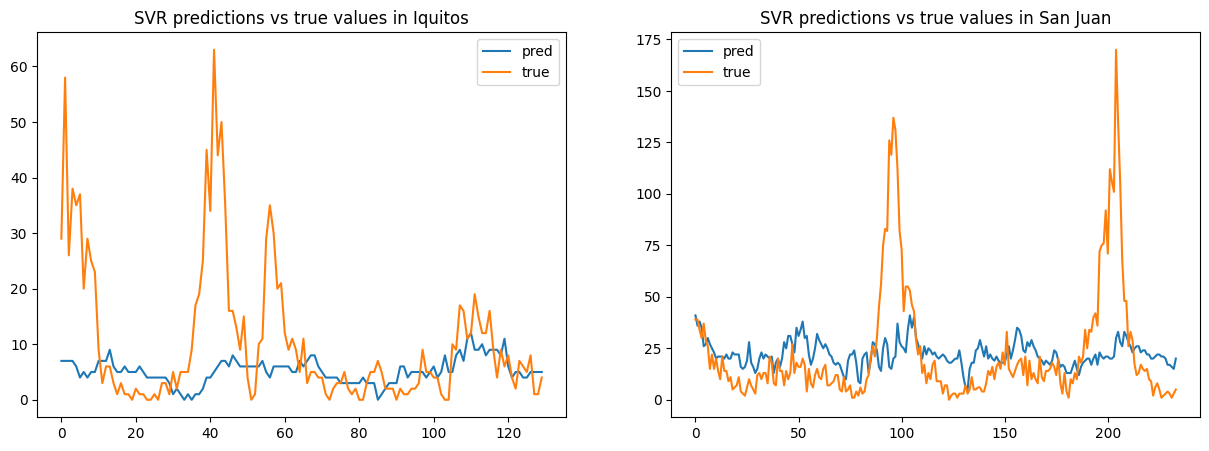

In [223]:
#Plotting predictions vs true values for testing data
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_test_pred, label='pred')
plt.plot(iq_y_test.values, label='true')
plt.legend()
plt.title('SVR predictions vs true values in Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_test_pred, label='pred')
plt.plot(sj_y_test.values, label='true')
plt.legend()
plt.title('SVR predictions vs true values in San Juan')
plt.show;

In [224]:
#Get training and testing metrics to check for over/underfitting
sj_svr_metrics = reg_metrics(sj_y_train, sj_train_pred, sj_y_test, sj_test_pred,'San Juan SVR')
iq_svr_metrics = reg_metrics(iq_y_train, iq_train_pred, iq_y_test, iq_test_pred,'Iquitos SVR')

sj_svr_metrics, iq_svr_metrics

(              test_mae  train_mae
 San Juan SVR                     
 0             17.07265  25.192308,
              test_mae  train_mae
 Iquitos SVR                     
 0            7.876923   4.633333)

Overfitting  in Iquitos and underfitting in San Juan

In [225]:
#Concatenating training and testing predictions and true values for visualization
iq_total_pred = np.hstack((iq_train_pred,iq_test_pred))
iq_true_values = np.hstack((iq_y_train.values,iq_y_test.values))

sj_total_pred = np.hstack((sj_train_pred,sj_test_pred))
sj_true_values = np.hstack((sj_y_train.values,sj_y_test.values))

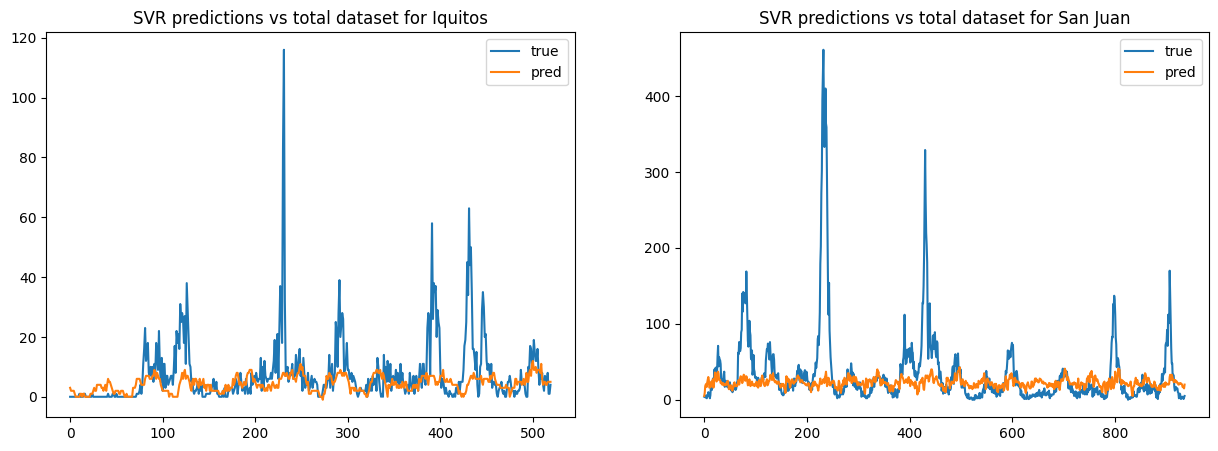

In [226]:
#Plotting predictions vs true values for entire dataset
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_true_values, label='true')
plt.plot(iq_total_pred, label='pred')
plt.legend()
plt.title('SVR predictions vs total dataset for Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_true_values, label='true')
plt.plot(sj_total_pred, label='pred')
plt.legend()
plt.title('SVR predictions vs total dataset for San Juan')
plt.show;

In this visualization we can clearly see that the SVR is underfitting for San Juan and hence not able to detect the patterns of the data well.

In [228]:
#Using the boosting function to boost the peaks of the predictions
sj_boost = peak_boost(sj_total_pred, 1.5,'pos')
iq_boost = peak_boost(iq_total_pred, 2, 'max')

Values are doubled over this threshold: 53.48749999999998
Values are doubled over this threshold: 16.309999999999945


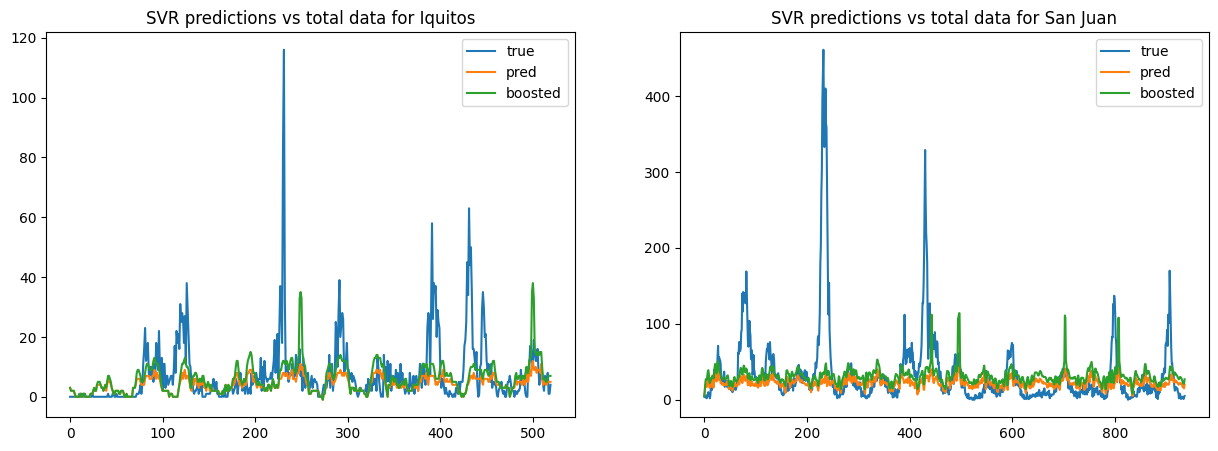

In [229]:
#Plotting boosted predictions vs true values and regular predictions for entire dataset
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_true_values, label='true')
plt.plot(iq_total_pred, label='pred')
plt.plot(iq_boost, label='boosted')
plt.legend()
plt.title('SVR predictions vs total data for Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_true_values, label='true')
plt.plot(sj_total_pred, label='pred')
plt.plot(sj_boost, label='boosted')
plt.legend()
plt.title('SVR predictions vs total data for San Juan')
plt.show;

In [230]:
sj_train_boost = peak_boost(sj_train_pred, 1.5, 'pos')
sj_test_boost = peak_boost(sj_test_pred, 1.5, 'pos')
iq_train_boost = peak_boost(iq_train_pred, 2, 'max')
iq_test_boost = peak_boost(iq_test_pred, 2, 'max')

Values are doubled over this threshold: 52.98875000000001
Values are doubled over this threshold: 36.125
Values are doubled over this threshold: 15.0
Values are doubled over this threshold: 13.209999999999994


In [231]:
#Get metrics after boosting
sj_svr_metrics = reg_metrics(sj_y_train, sj_train_boost, sj_y_test, sj_test_boost,'San Juan SVR')
iq_svr_metrics = reg_metrics(iq_y_train, iq_train_boost, iq_y_test, iq_test_boost,'Iquitos SVR')

sj_svr_metrics, iq_svr_metrics

(               test_mae  train_mae
 San Juan SVR                      
 0             15.038462  26.554131,
              test_mae  train_mae
 Iquitos SVR                     
 0            8.084615   4.897436)

### Gradient Boosting Regressor

In [232]:
#Define the parameters for the Grid Search
gb_params = {
    'n_estimators': [40,50,60,70],
    'loss': ['absolute_error'],
    'learning_rate': [0.001,0.01,0.1,0.5]
}

In [233]:
# #Grid Search SJ
# start = time.time()

# gb = GradientBoostingRegressor()
# search_gb = GridSearchCV(gb, param_grid=gb_params, 
#                               cv=TimeSeriesSplit(n_splits=5), n_jobs=-1, verbose=1, scoring='neg_mean_absolute_error')
# search_gb.fit(sj_X, sj_y);
# sj_gb_params = search_gb.best_params_
# print(f'MAE: {abs(search_gb.best_score_)}')

# executionTime = (time.time() - start)
# print("Execution time:",
#       np.round(executionTime,2)," seconds")

In [234]:
# #Grid Search IQ
# start = time.time()

# gb = GradientBoostingRegressor()
# search_gb = GridSearchCV(gb, param_grid=gb_params, 
#                               cv=TimeSeriesSplit(n_splits=5), n_jobs=-1, verbose=1, scoring='neg_mean_absolute_error')
# search_gb.fit(iq_X, iq_y);
# iq_gb_params = search_gb.best_params_
# print(f'MAE: {abs(search_gb.best_score_)}')

# executionTime = (time.time() - start)
# print("Execution time:",
#       np.round(executionTime,2)," seconds")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
MAE: 6.610250850310393
Execution time: 11.48  seconds


In [236]:
#Storing results from Grid Search
sj_gb_params = {'learning_rate': 0.01, 'loss': 'absolute_error', 'n_estimators': 40}
iq_gb_params = {'learning_rate': 0.1, 'loss': 'absolute_error', 'n_estimators': 50}

In [238]:
#Initialize models
sj_gb_model = GradientBoostingRegressor(**sj_gb_params)
iq_gb_model = GradientBoostingRegressor(**iq_gb_params)

#Fitting models on training data
sj_gb_model.fit(sj_X_train, sj_y_train)
iq_gb_model.fit(iq_X_train, iq_y_train)
print('Training Complete!')

#Making predictions on training and testing data for San Juan
sj_train_pred = sj_gb_model.predict(sj_X_train).astype(int)
sj_test_pred = sj_gb_model.predict(sj_X_test).astype(int) 

#Making predictions on training and testing data for Iquitos
iq_test_pred = iq_gb_model.predict(iq_X_test).astype(int)
iq_train_pred = iq_gb_model.predict(iq_X_train).astype(int)

Training Complete!


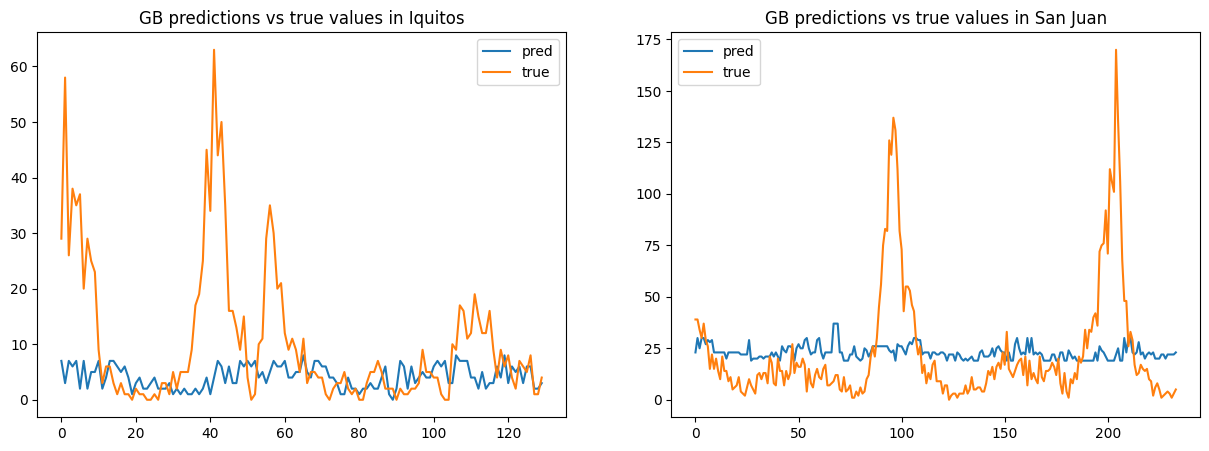

In [239]:
#Plotting predictions vs true values for testing data
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_test_pred, label='pred')
plt.plot(iq_y_test.values, label='true')
plt.legend()
plt.title('GB predictions vs true values in Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_test_pred, label='pred')
plt.plot(sj_y_test.values, label='true')
plt.legend()
plt.title('GB predictions vs true values in San Juan')
plt.show;

In [240]:
#Concatenating training and testing predictions and true values for visualization
iq_total_pred = np.hstack((iq_train_pred,iq_test_pred))
iq_true_values = np.hstack((iq_y_train.values,iq_y_test.values))

sj_total_pred = np.hstack((sj_train_pred,sj_test_pred))
sj_true_values = np.hstack((sj_y_train.values,sj_y_test.values))

In [241]:
#Using the boosting function to boost the peaks of the predictions
sj_boost = peak_boost(sj_total_pred, 1.5,'pos')
iq_boost = peak_boost(iq_total_pred, 2.5, 'max')

Values are doubled over this threshold: 35.5
Values are doubled over this threshold: 17.0


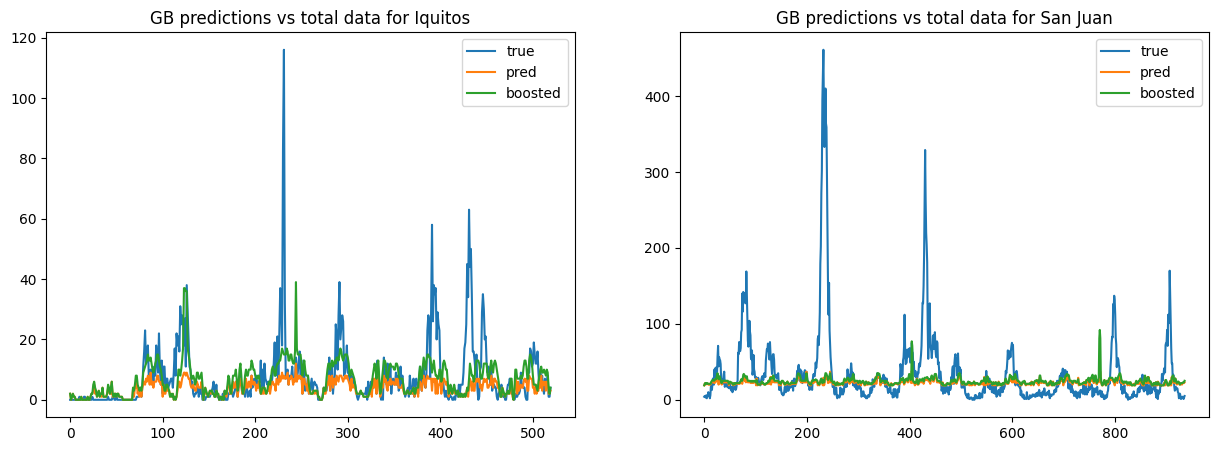

In [242]:
#Plotting boosted predictions vs true values and regular predictions for entire dataset
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_true_values, label='true')
plt.plot(iq_total_pred, label='pred')
plt.plot(iq_boost, label='boosted')
plt.legend()
plt.title('GB predictions vs total data for Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_true_values, label='true')
plt.plot(sj_total_pred, label='pred')
plt.plot(sj_boost, label='boosted')
plt.legend()
plt.title('GB predictions vs total data for San Juan')
plt.show;

In [243]:
sj_train_boost = peak_boost(sj_train_pred, 1.5, 'pos')
sj_test_boost = peak_boost(sj_test_pred, 1.5, 'pos')
iq_train_boost = peak_boost(iq_train_pred, 2, 'max')
iq_test_boost = peak_boost(iq_test_pred, 2, 'max')

Values are doubled over this threshold: 35.5
Values are doubled over this threshold: 36.893749999999926
Values are doubled over this threshold: 15.0
Values are doubled over this threshold: 8.0


In [245]:
#Get metrics after boosting
sj_gb_metrics = reg_metrics(sj_y_train, sj_train_boost, sj_y_test, sj_test_boost,'San Juan GB')
iq_gb_metrics = reg_metrics(iq_y_train, iq_train_boost, iq_y_test, iq_test_boost,'Iquitos GB')

sj_gb_metrics, iq_gb_metrics

(              test_mae  train_mae
 San Juan GB                      
 0            18.559829  25.064103,
             test_mae  train_mae
 Iquitos GB                     
 0           8.238462   3.917949)

### Random Forest

In [80]:
#Define the parameters we want to use for the Grid Search
rf_params = {
    'max_depth': [None],
    'warm_start': [False],
    'max_features': [5,10,15,20],
    'min_samples_leaf': [3,4,6,8],
    'min_samples_split': [3],
    'n_estimators': [90,100,150,200,300],
}

In [78]:
# #Grid Search SJ
# start = time.time()

# rf = RandomForestRegressor(criterion='absolute_error')
# search_rf = GridSearchCV(rf, param_grid=rf_params, 
#                               cv=TimeSeriesSplit(n_splits=5), n_jobs=-1, verbose=1, scoring='neg_mean_absolute_error')
# search_rf.fit(sj_X, sj_y);
# sj_rf_params = search_rf.best_params_
# print(f'MAE: {abs(search_rf.best_score_)}')

# executionTime = (time.time() - start)
# print("Execution time:",
#       np.round(executionTime,2)," seconds")

Fitting 5 folds for each of 160 candidates, totalling 800 fits
MAE: 26.83544871794872
Execution time: 893.95  seconds


In [81]:
# #Grid Search IQ
# start = time.time()

# rf = RandomForestRegressor(criterion='absolute_error')
# search_rf = GridSearchCV(rf, param_grid=rf_params, 
#                               cv=TimeSeriesSplit(n_splits=5), n_jobs=-1, verbose=1, scoring='neg_mean_absolute_error')
# search_rf.fit(iq_X, iq_y);
# iq_rf_params = search_rf.best_params_
# print(f'MAE: {abs(search_rf.best_score_)}')

# executionTime = (time.time() - start)
# print("Execution time:",
#       np.round(executionTime,2)," seconds")

Fitting 5 folds for each of 80 candidates, totalling 400 fits
MAE: 6.380723514211885
Execution time: 171.04  seconds


In [90]:
#Storing results from Grid Search
sj_rf_params = {'max_depth': None,
 'max_features': 5,
 'min_samples_leaf': 6,
 'min_samples_split': 3,
 'n_estimators': 90,
 'warm_start': False}

iq_rf_params = {'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 90,
 'warm_start': False}

In [202]:
#Initialize models
sj_rf_model = RandomForestRegressor(**sj_rf_params, criterion='absolute_error')
iq_rf_model = RandomForestRegressor(**sj_rf_params, criterion='absolute_error')

#Fitting models on training data
sj_rf_model.fit(sj_X_train, sj_y_train)
iq_rf_model.fit(iq_X_train, iq_y_train)

print('Training Complete!')

#Making predictions on training and testing data for San Juan
sj_train_pred = sj_rf_model.predict(sj_X_train).astype(int)
sj_test_pred = sj_rf_model.predict(sj_X_test).astype(int) 

#Making predictions on training and testing data for Iquitos
iq_test_pred = iq_rf_model.predict(iq_X_test).astype(int)
iq_train_pred = iq_rf_model.predict(iq_X_train).astype(int)

Training Complete!


Trial and error revealed that the Iquitos model performed better with the grid search hyper parameters from San Juan, therefore those hyper parameters were used for both models.

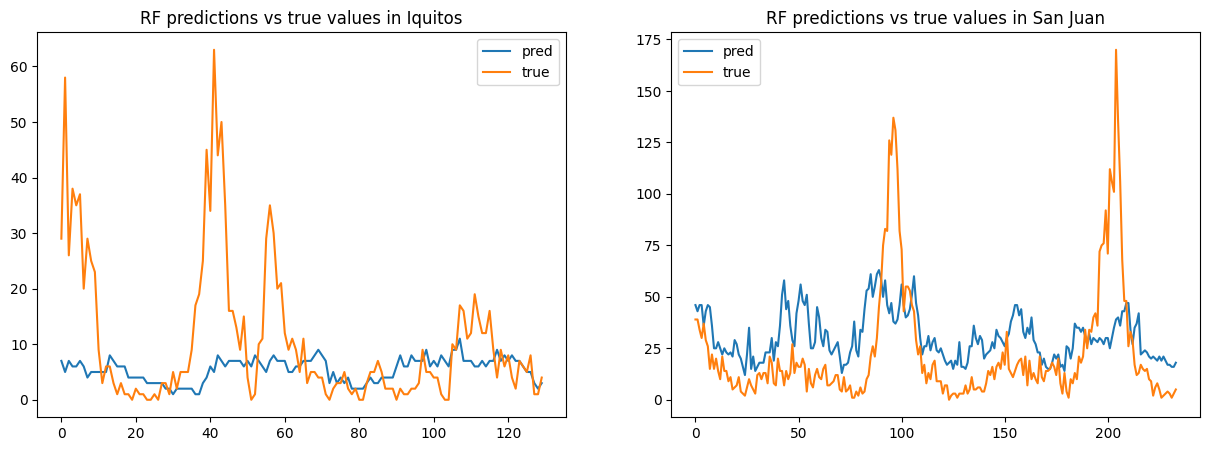

In [203]:
#Plotting true values vs predictions on testing data
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_test_pred, label='pred')
plt.plot(iq_y_test.values, label='true')
plt.legend()
plt.title('RF predictions vs true values in Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_test_pred, label='pred')
plt.plot(sj_y_test.values, label='true')
plt.legend()
plt.title('RF predictions vs true values in San Juan')
plt.show;

In [204]:
#Concatenating training and testing predictions and values for visualizations
iq_total_pred = np.hstack((iq_train_pred,iq_test_pred))
iq_true_values = np.hstack((iq_y_train.values,iq_y_test.values))

sj_total_pred = np.hstack((sj_train_pred,sj_test_pred))
sj_true_values = np.hstack((sj_y_train.values,sj_y_test.values))

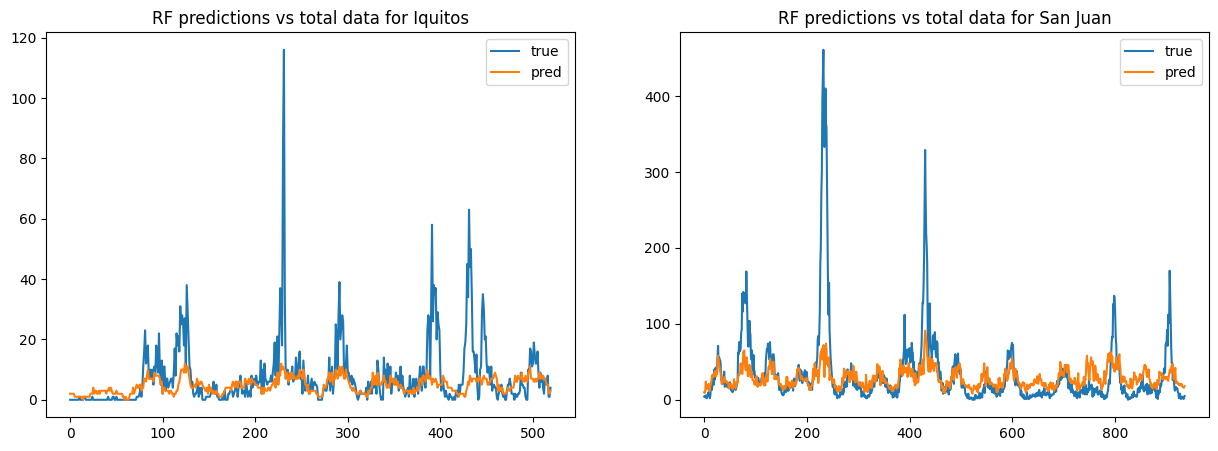

In [205]:
#Plotting true values vs predictions on whole dataset
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_true_values, label='true')
plt.plot(iq_total_pred, label='pred')
plt.legend()
plt.title('RF predictions vs total data for Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_true_values, label='true')
plt.plot(sj_total_pred, label='pred')
plt.legend()
plt.title('RF predictions vs total data for San Juan')
plt.show;

In [206]:
# Get training and testing metrics to check for overfitting
sj_rf_metrics = reg_metrics(sj_y_train, sj_train_pred, sj_y_test, sj_test_pred,'San Juan RF')
iq_rf_metrics = reg_metrics(iq_y_train, iq_train_pred, iq_y_test, iq_test_pred,'Iquitos RF')

sj_rf_metrics, iq_rf_metrics

(             test_mae  train_mae
 San Juan RF                     
 0            20.17094  20.286325,
             test_mae  train_mae
 Iquitos RF                     
 0           7.907692   3.917949)

In [211]:
#Using the peak boosting function to scale the predictions
print('San Juan:')
sj_boost = peak_boost(sj_total_pred, 1.5,'pos')
print('Iquitos:')
iq_boost = peak_boost(iq_total_pred, 2, 'max')

San Juan:
Values are doubled over this threshold: 89.5
Iquitos:
Values are doubled over this threshold: 18.904999999999973


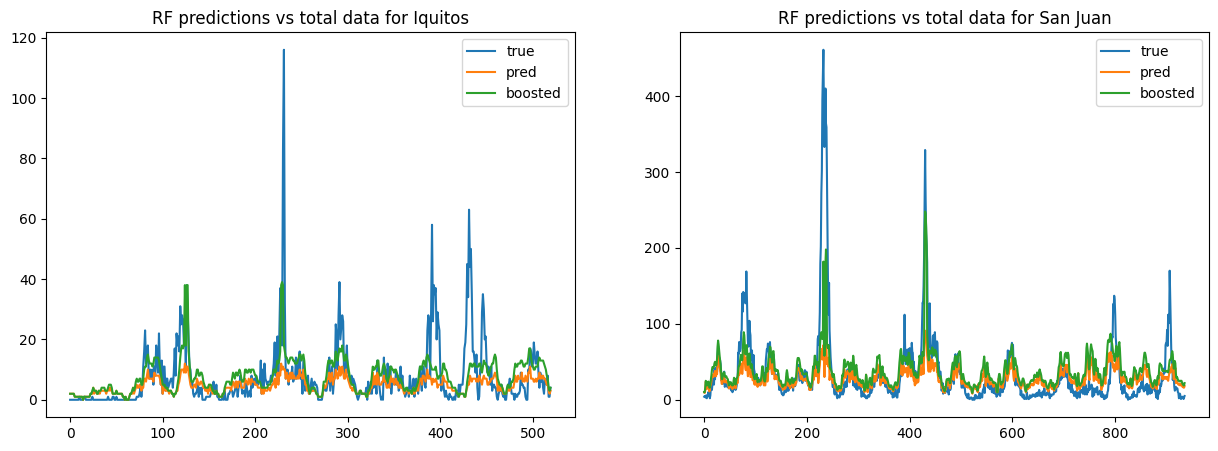

In [212]:
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_true_values, label='true')
plt.plot(iq_total_pred, label='pred')
plt.plot(iq_boost, label='boosted')
plt.legend()
plt.title('RF predictions vs total data for Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_true_values, label='true')
plt.plot(sj_total_pred, label='pred')
plt.plot(sj_boost, label='boosted')
plt.legend()
plt.title('RF predictions vs total data for San Juan')
plt.show;

In [213]:
sj_train_boost = peak_boost(sj_train_pred, 1.5, 'pos')
sj_test_boost = peak_boost(sj_test_pred, 1.5, 'pos')
iq_train_boost = peak_boost(iq_train_pred, 2, 'max')
iq_test_boost = peak_boost(iq_test_pred, 2, 'max')

Values are doubled over this threshold: 90.62125
Values are doubled over this threshold: 63.00624999999998
Values are doubled over this threshold: 19.0
Values are doubled over this threshold: 11.419999999999987


In [214]:
#Get metrics after boosting
sj_rf_metrics = reg_metrics(sj_y_train, sj_train_boost, sj_y_test, sj_test_boost,'San Juan RF')
iq_rf_metrics = reg_metrics(iq_y_train, iq_train_boost, iq_y_test, iq_test_boost,'Iquitos RF')

sj_rf_metrics, iq_rf_metrics

(              test_mae  train_mae
 San Juan RF                      
 0            16.623932  19.420228,
             test_mae  train_mae
 Iquitos RF                     
 0           8.023077   4.238462)

### XGBoost

In [177]:
print(xgboost.__version__)

1.7.1


In [178]:
#Define the parameters we want to use for the Grid Search
xgb_params = {
    'max_depth': [5,6,7,8,9,10],
    'eta': [0.3,0.1,0.01],
    'seed': [5,6,7,8,9,10],
    'n_estimators': [100,300,600,1000]
}

In [96]:
# #Grid Search SJ
# start = time.time()

# xgb = xgboost.XGBRegressor()
# search_xgb = GridSearchCV(xgb, param_grid=xgb_params, 
#                               cv=TimeSeriesSplit(n_splits=5), n_jobs=2, verbose=2, scoring='neg_mean_absolute_error')
# search_xgb.fit(sj_X, sj_y);
# sj_xgb_params = search_xgb.best_params_
# print(f'MAE: {abs(search_xgb.best_score_)}')

# executionTime = (time.time() - start)
# print("Execution time:",
#       np.round(executionTime,2)," seconds")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=5; total time=   0.4s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=5; total time=   0.9s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=6; total time=   0.3s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=6; total time=   0.6s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=6; total time=   0.8s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=7; total time=   0.2s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=7; total time=   0.4s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=7; total time=   0.8s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=8; total time=   0.2s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=8; total time=   0.5s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=8; total time=   0.5s
[CV] END .....eta=0.3, max_depth=5, n_estimat

[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=5; total time=   0.3s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=5; total time=   0.9s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=5; total time=   0.8s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=6; total time=   0.7s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=6; total time=   0.8s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=7; total time=   0.7s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=7; total time=   0.7s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=8; total time=   0.4s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=8; total time=   0.5s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=9; total time=   0.4s
[CV] END .....eta=0.3, max_depth=5, n_estimators=100, seed=9; total time=   0.5s
[CV] END ....eta=0.3, max_depth=5, n_estimators=100, seed=10; total time=   0.6s
[CV] END .....eta=0.3, max_d

[CV] END .....eta=0.3, max_depth=8, n_estimators=300, seed=9; total time=   0.7s
[CV] END .....eta=0.3, max_depth=8, n_estimators=300, seed=9; total time=   1.2s
[CV] END ....eta=0.3, max_depth=8, n_estimators=300, seed=10; total time=   0.6s
[CV] END ....eta=0.3, max_depth=8, n_estimators=300, seed=10; total time=   1.2s
[CV] END .....eta=0.3, max_depth=8, n_estimators=600, seed=5; total time=   0.9s
[CV] END .....eta=0.3, max_depth=8, n_estimators=600, seed=5; total time=   1.7s
[CV] END .....eta=0.3, max_depth=8, n_estimators=600, seed=6; total time=   1.9s
[CV] END .....eta=0.3, max_depth=8, n_estimators=600, seed=6; total time=   1.5s
[CV] END .....eta=0.3, max_depth=8, n_estimators=600, seed=7; total time=   1.2s
[CV] END .....eta=0.3, max_depth=8, n_estimators=600, seed=8; total time=   0.6s
[CV] END .....eta=0.3, max_depth=8, n_estimators=600, seed=8; total time=   1.7s
[CV] END .....eta=0.3, max_depth=8, n_estimators=600, seed=8; total time=   2.0s
[CV] END .....eta=0.3, max_d

[CV] END .....eta=0.3, max_depth=8, n_estimators=300, seed=6; total time=   0.4s
[CV] END .....eta=0.3, max_depth=8, n_estimators=300, seed=6; total time=   0.6s
[CV] END .....eta=0.3, max_depth=8, n_estimators=300, seed=6; total time=   1.2s
[CV] END .....eta=0.3, max_depth=8, n_estimators=300, seed=7; total time=   0.9s
[CV] END .....eta=0.3, max_depth=8, n_estimators=300, seed=8; total time=   0.3s
[CV] END .....eta=0.3, max_depth=8, n_estimators=300, seed=8; total time=   0.4s
[CV] END .....eta=0.3, max_depth=8, n_estimators=300, seed=8; total time=   0.7s
[CV] END .....eta=0.3, max_depth=8, n_estimators=300, seed=8; total time=   1.3s
[CV] END .....eta=0.3, max_depth=8, n_estimators=300, seed=9; total time=   0.9s
[CV] END ....eta=0.3, max_depth=8, n_estimators=300, seed=10; total time=   0.3s
[CV] END ....eta=0.3, max_depth=8, n_estimators=300, seed=10; total time=   0.4s
[CV] END ....eta=0.3, max_depth=8, n_estimators=300, seed=10; total time=   0.9s
[CV] END .....eta=0.3, max_d

[CV] END .....eta=0.1, max_depth=5, n_estimators=600, seed=9; total time=   2.2s
[CV] END ....eta=0.1, max_depth=5, n_estimators=600, seed=10; total time=   0.6s
[CV] END ....eta=0.1, max_depth=5, n_estimators=600, seed=10; total time=   1.2s
[CV] END ....eta=0.1, max_depth=5, n_estimators=600, seed=10; total time=   1.8s
[CV] END ....eta=0.1, max_depth=5, n_estimators=600, seed=10; total time=   2.7s
[CV] END ....eta=0.1, max_depth=5, n_estimators=1000, seed=5; total time=   2.4s
[CV] END ....eta=0.1, max_depth=5, n_estimators=1000, seed=5; total time=   4.5s
[CV] END ....eta=0.1, max_depth=5, n_estimators=1000, seed=6; total time=   3.5s
[CV] END ....eta=0.1, max_depth=5, n_estimators=1000, seed=7; total time=   0.8s
[CV] END ....eta=0.1, max_depth=5, n_estimators=1000, seed=7; total time=   1.6s
[CV] END ....eta=0.1, max_depth=5, n_estimators=1000, seed=7; total time=   2.4s
[CV] END ....eta=0.1, max_depth=5, n_estimators=1000, seed=7; total time=   5.0s
[CV] END ....eta=0.1, max_de

[CV] END ....eta=0.1, max_depth=5, n_estimators=1000, seed=6; total time=   0.8s
[CV] END ....eta=0.1, max_depth=5, n_estimators=1000, seed=6; total time=   1.5s
[CV] END ....eta=0.1, max_depth=5, n_estimators=1000, seed=6; total time=   2.4s
[CV] END ....eta=0.1, max_depth=5, n_estimators=1000, seed=6; total time=   4.6s
[CV] END ....eta=0.1, max_depth=5, n_estimators=1000, seed=7; total time=   4.0s
[CV] END ....eta=0.1, max_depth=5, n_estimators=1000, seed=8; total time=   0.8s
[CV] END ....eta=0.1, max_depth=5, n_estimators=1000, seed=8; total time=   1.5s
[CV] END ....eta=0.1, max_depth=5, n_estimators=1000, seed=8; total time=   2.4s
[CV] END ....eta=0.1, max_depth=5, n_estimators=1000, seed=8; total time=   4.6s
[CV] END ....eta=0.1, max_depth=5, n_estimators=1000, seed=9; total time=   3.5s
[CV] END ...eta=0.1, max_depth=5, n_estimators=1000, seed=10; total time=   0.8s
[CV] END ...eta=0.1, max_depth=5, n_estimators=1000, seed=10; total time=   1.5s
[CV] END ...eta=0.1, max_dep

[CV] END ....eta=0.1, max_depth=9, n_estimators=100, seed=10; total time=   0.2s
[CV] END ....eta=0.1, max_depth=9, n_estimators=100, seed=10; total time=   0.4s
[CV] END ....eta=0.1, max_depth=9, n_estimators=100, seed=10; total time=   0.5s
[CV] END ....eta=0.1, max_depth=9, n_estimators=100, seed=10; total time=   0.8s
[CV] END .....eta=0.1, max_depth=9, n_estimators=300, seed=5; total time=   1.5s
[CV] END .....eta=0.1, max_depth=9, n_estimators=300, seed=5; total time=   2.7s
[CV] END .....eta=0.1, max_depth=9, n_estimators=300, seed=6; total time=   1.5s
[CV] END .....eta=0.1, max_depth=9, n_estimators=300, seed=6; total time=   2.7s
[CV] END .....eta=0.1, max_depth=9, n_estimators=300, seed=7; total time=   2.2s
[CV] END .....eta=0.1, max_depth=9, n_estimators=300, seed=8; total time=   0.5s
[CV] END .....eta=0.1, max_depth=9, n_estimators=300, seed=8; total time=   1.0s
[CV] END .....eta=0.1, max_depth=9, n_estimators=300, seed=8; total time=   1.6s
[CV] END .....eta=0.1, max_d

[CV] END .....eta=0.1, max_depth=9, n_estimators=100, seed=6; total time=   0.2s
[CV] END .....eta=0.1, max_depth=9, n_estimators=100, seed=6; total time=   0.4s
[CV] END .....eta=0.1, max_depth=9, n_estimators=100, seed=6; total time=   0.7s
[CV] END .....eta=0.1, max_depth=9, n_estimators=100, seed=7; total time=   0.2s
[CV] END .....eta=0.1, max_depth=9, n_estimators=100, seed=7; total time=   0.4s
[CV] END .....eta=0.1, max_depth=9, n_estimators=100, seed=7; total time=   0.7s
[CV] END .....eta=0.1, max_depth=9, n_estimators=100, seed=8; total time=   0.2s
[CV] END .....eta=0.1, max_depth=9, n_estimators=100, seed=8; total time=   0.4s
[CV] END .....eta=0.1, max_depth=9, n_estimators=100, seed=8; total time=   0.7s
[CV] END .....eta=0.1, max_depth=9, n_estimators=100, seed=9; total time=   0.2s
[CV] END .....eta=0.1, max_depth=9, n_estimators=100, seed=9; total time=   0.4s
[CV] END .....eta=0.1, max_depth=9, n_estimators=100, seed=9; total time=   0.6s
[CV] END .....eta=0.1, max_d

MAE: 24.959503848124776
Execution time: 1905.92  seconds


In [98]:
# #Grid Search IQ
# start = time.time()

# xgb = xgboost.XGBRegressor()
# search_xgb = GridSearchCV(xgb, param_grid=xgb_params, 
#                               cv=TimeSeriesSplit(n_splits=5), n_jobs=2, verbose=2, scoring='neg_mean_absolute_error')
# search_xgb.fit(iq_X, iq_y);
# iq_xgb_params = search_xgb.best_params_
# print(f'MAE: {abs(search_xgb.best_score_)}')

# executionTime = (time.time() - start)
# print("Execution time:",
#       np.round(executionTime,2)," seconds")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END ....eta=0.01, max_depth=6, n_estimators=300, seed=9; total time=   0.5s
[CV] END ....eta=0.01, max_depth=6, n_estimators=300, seed=9; total time=   0.8s
[CV] END ....eta=0.01, max_depth=6, n_estimators=300, seed=9; total time=   1.4s
[CV] END ...eta=0.01, max_depth=6, n_estimators=300, seed=10; total time=   0.5s
[CV] END ...eta=0.01, max_depth=6, n_estimators=300, seed=10; total time=   0.8s
[CV] END ...eta=0.01, max_depth=6, n_estimators=300, seed=10; total time=   1.5s
[CV] END ....eta=0.01, max_depth=6, n_estimators=600, seed=5; total time=   1.0s
[CV] END ....eta=0.01, max_depth=6, n_estimators=600, seed=5; total time=   2.4s
[CV] END ....eta=0.01, max_depth=6, n_estimators=600, seed=5; total time=   3.5s
[CV] END ....eta=0.01, max_depth=6, n_estimators=600, seed=6; total time=   2.3s
[CV] END ....eta=0.01, max_depth=6, n_estimators=600, seed=6; total time=   3.6s
[CV] END ....eta=0.01, max_depth=6, n_estimat

[CV] END ....eta=0.01, max_depth=6, n_estimators=600, seed=6; total time=   1.0s
[CV] END ....eta=0.01, max_depth=6, n_estimators=600, seed=6; total time=   1.6s
[CV] END ....eta=0.01, max_depth=6, n_estimators=600, seed=6; total time=   2.9s
[CV] END ....eta=0.01, max_depth=6, n_estimators=600, seed=7; total time=   1.1s
[CV] END ....eta=0.01, max_depth=6, n_estimators=600, seed=7; total time=   1.6s
[CV] END ....eta=0.01, max_depth=6, n_estimators=600, seed=7; total time=   2.8s
[CV] END ....eta=0.01, max_depth=6, n_estimators=600, seed=8; total time=   1.0s
[CV] END ....eta=0.01, max_depth=6, n_estimators=600, seed=8; total time=   1.7s
[CV] END ....eta=0.01, max_depth=6, n_estimators=600, seed=8; total time=   3.0s
[CV] END ....eta=0.01, max_depth=6, n_estimators=600, seed=9; total time=   1.1s
[CV] END ....eta=0.01, max_depth=6, n_estimators=600, seed=9; total time=   1.7s
[CV] END ....eta=0.01, max_depth=6, n_estimators=600, seed=9; total time=   3.1s
[CV] END ...eta=0.01, max_de

[CV] END ...eta=0.01, max_depth=9, n_estimators=1000, seed=6; total time=   5.0s
[CV] END ...eta=0.01, max_depth=9, n_estimators=1000, seed=6; total time=   8.0s
[CV] END ...eta=0.01, max_depth=9, n_estimators=1000, seed=7; total time=   5.1s
[CV] END ...eta=0.01, max_depth=9, n_estimators=1000, seed=7; total time=   7.9s
[CV] END ...eta=0.01, max_depth=9, n_estimators=1000, seed=8; total time=   6.6s
[CV] END ...eta=0.01, max_depth=9, n_estimators=1000, seed=9; total time=   1.9s
[CV] END ...eta=0.01, max_depth=9, n_estimators=1000, seed=9; total time=   3.5s
[CV] END ...eta=0.01, max_depth=9, n_estimators=1000, seed=9; total time=   5.1s
[CV] END ...eta=0.01, max_depth=9, n_estimators=1000, seed=9; total time=   7.9s
[CV] END ..eta=0.01, max_depth=9, n_estimators=1000, seed=10; total time=   6.6s
[CV] END ...eta=0.01, max_depth=10, n_estimators=100, seed=5; total time=   0.2s
[CV] END ...eta=0.01, max_depth=10, n_estimators=100, seed=5; total time=   0.4s
[CV] END ...eta=0.01, max_de

[CV] END ...eta=0.01, max_depth=9, n_estimators=1000, seed=7; total time=   6.6s
[CV] END ...eta=0.01, max_depth=9, n_estimators=1000, seed=8; total time=   1.9s
[CV] END ...eta=0.01, max_depth=9, n_estimators=1000, seed=8; total time=   3.5s
[CV] END ...eta=0.01, max_depth=9, n_estimators=1000, seed=8; total time=   5.0s
[CV] END ...eta=0.01, max_depth=9, n_estimators=1000, seed=8; total time=   8.0s
[CV] END ...eta=0.01, max_depth=9, n_estimators=1000, seed=9; total time=   6.6s
[CV] END ..eta=0.01, max_depth=9, n_estimators=1000, seed=10; total time=   1.9s
[CV] END ..eta=0.01, max_depth=9, n_estimators=1000, seed=10; total time=   3.5s
[CV] END ..eta=0.01, max_depth=9, n_estimators=1000, seed=10; total time=   5.0s
[CV] END ..eta=0.01, max_depth=9, n_estimators=1000, seed=10; total time=   8.0s
[CV] END ...eta=0.01, max_depth=10, n_estimators=100, seed=7; total time=   0.2s
[CV] END ...eta=0.01, max_depth=10, n_estimators=100, seed=7; total time=   0.5s
[CV] END ...eta=0.01, max_de

[CV] END .....eta=0.3, max_depth=7, n_estimators=100, seed=7; total time=   0.3s
[CV] END .....eta=0.3, max_depth=7, n_estimators=100, seed=8; total time=   0.1s
[CV] END .....eta=0.3, max_depth=7, n_estimators=100, seed=8; total time=   0.1s
[CV] END .....eta=0.3, max_depth=7, n_estimators=100, seed=8; total time=   0.2s
[CV] END .....eta=0.3, max_depth=7, n_estimators=100, seed=8; total time=   0.4s
[CV] END .....eta=0.3, max_depth=7, n_estimators=100, seed=9; total time=   0.3s
[CV] END ....eta=0.3, max_depth=7, n_estimators=100, seed=10; total time=   0.1s
[CV] END ....eta=0.3, max_depth=7, n_estimators=100, seed=10; total time=   0.1s
[CV] END ....eta=0.3, max_depth=7, n_estimators=100, seed=10; total time=   0.2s
[CV] END ....eta=0.3, max_depth=7, n_estimators=100, seed=10; total time=   0.4s
[CV] END .....eta=0.3, max_depth=7, n_estimators=300, seed=5; total time=   0.4s
[CV] END .....eta=0.3, max_depth=7, n_estimators=300, seed=5; total time=   0.6s
[CV] END .....eta=0.3, max_d

[CV] END .....eta=0.3, max_depth=7, n_estimators=300, seed=6; total time=   0.3s
[CV] END .....eta=0.3, max_depth=7, n_estimators=300, seed=6; total time=   0.4s
[CV] END .....eta=0.3, max_depth=7, n_estimators=300, seed=7; total time=   0.2s
[CV] END .....eta=0.3, max_depth=7, n_estimators=300, seed=7; total time=   0.3s
[CV] END .....eta=0.3, max_depth=7, n_estimators=300, seed=7; total time=   0.4s
[CV] END .....eta=0.3, max_depth=7, n_estimators=300, seed=8; total time=   0.2s
[CV] END .....eta=0.3, max_depth=7, n_estimators=300, seed=8; total time=   0.3s
[CV] END .....eta=0.3, max_depth=7, n_estimators=300, seed=8; total time=   0.4s
[CV] END .....eta=0.3, max_depth=7, n_estimators=300, seed=8; total time=   0.5s
[CV] END .....eta=0.3, max_depth=7, n_estimators=300, seed=9; total time=   0.4s
[CV] END ....eta=0.3, max_depth=7, n_estimators=300, seed=10; total time=   0.2s
[CV] END ....eta=0.3, max_depth=7, n_estimators=300, seed=10; total time=   0.2s
[CV] END ....eta=0.3, max_de

[CV] END ...eta=0.3, max_depth=10, n_estimators=300, seed=10; total time=   0.2s
[CV] END ...eta=0.3, max_depth=10, n_estimators=300, seed=10; total time=   0.3s
[CV] END ...eta=0.3, max_depth=10, n_estimators=300, seed=10; total time=   0.4s
[CV] END ....eta=0.3, max_depth=10, n_estimators=600, seed=5; total time=   0.3s
[CV] END ....eta=0.3, max_depth=10, n_estimators=600, seed=5; total time=   0.6s
[CV] END ....eta=0.3, max_depth=10, n_estimators=600, seed=5; total time=   0.8s
[CV] END ....eta=0.3, max_depth=10, n_estimators=600, seed=6; total time=   0.5s
[CV] END ....eta=0.3, max_depth=10, n_estimators=600, seed=6; total time=   0.7s
[CV] END ....eta=0.3, max_depth=10, n_estimators=600, seed=7; total time=   0.3s
[CV] END ....eta=0.3, max_depth=10, n_estimators=600, seed=7; total time=   0.6s
[CV] END ....eta=0.3, max_depth=10, n_estimators=600, seed=7; total time=   0.8s
[CV] END ....eta=0.3, max_depth=10, n_estimators=600, seed=8; total time=   0.5s
[CV] END ....eta=0.3, max_de

[CV] END ....eta=0.3, max_depth=10, n_estimators=600, seed=9; total time=   0.5s
[CV] END ....eta=0.3, max_depth=10, n_estimators=600, seed=9; total time=   0.8s
[CV] END ...eta=0.3, max_depth=10, n_estimators=600, seed=10; total time=   0.5s
[CV] END ...eta=0.3, max_depth=10, n_estimators=600, seed=10; total time=   0.8s
[CV] END ...eta=0.3, max_depth=10, n_estimators=1000, seed=5; total time=   0.6s
[CV] END ...eta=0.3, max_depth=10, n_estimators=1000, seed=5; total time=   0.9s
[CV] END ...eta=0.3, max_depth=10, n_estimators=1000, seed=6; total time=   0.5s
[CV] END ...eta=0.3, max_depth=10, n_estimators=1000, seed=6; total time=   0.6s
[CV] END ...eta=0.3, max_depth=10, n_estimators=1000, seed=6; total time=   0.9s
[CV] END ...eta=0.3, max_depth=10, n_estimators=1000, seed=7; total time=   0.5s
[CV] END ...eta=0.3, max_depth=10, n_estimators=1000, seed=7; total time=   0.8s
[CV] END ...eta=0.3, max_depth=10, n_estimators=1000, seed=7; total time=   1.1s
[CV] END ...eta=0.3, max_dep

[CV] END ....eta=0.1, max_depth=7, n_estimators=1000, seed=6; total time=   0.9s
[CV] END ....eta=0.1, max_depth=7, n_estimators=1000, seed=6; total time=   1.5s
[CV] END ....eta=0.1, max_depth=7, n_estimators=1000, seed=7; total time=   0.6s
[CV] END ....eta=0.1, max_depth=7, n_estimators=1000, seed=7; total time=   0.8s
[CV] END ....eta=0.1, max_depth=7, n_estimators=1000, seed=7; total time=   1.4s
[CV] END ....eta=0.1, max_depth=7, n_estimators=1000, seed=8; total time=   0.6s
[CV] END ....eta=0.1, max_depth=7, n_estimators=1000, seed=8; total time=   0.8s
[CV] END ....eta=0.1, max_depth=7, n_estimators=1000, seed=8; total time=   1.4s
[CV] END ....eta=0.1, max_depth=7, n_estimators=1000, seed=9; total time=   0.5s
[CV] END ....eta=0.1, max_depth=7, n_estimators=1000, seed=9; total time=   0.9s
[CV] END ....eta=0.1, max_depth=7, n_estimators=1000, seed=9; total time=   1.1s
[CV] END ....eta=0.1, max_depth=7, n_estimators=1000, seed=9; total time=   1.8s
[CV] END ...eta=0.1, max_dep

[CV] END .....eta=0.1, max_depth=8, n_estimators=100, seed=8; total time=   0.1s
[CV] END .....eta=0.1, max_depth=8, n_estimators=100, seed=8; total time=   0.2s
[CV] END .....eta=0.1, max_depth=8, n_estimators=100, seed=8; total time=   0.4s
[CV] END .....eta=0.1, max_depth=8, n_estimators=100, seed=9; total time=   0.1s
[CV] END .....eta=0.1, max_depth=8, n_estimators=100, seed=9; total time=   0.2s
[CV] END .....eta=0.1, max_depth=8, n_estimators=100, seed=9; total time=   0.4s
[CV] END ....eta=0.1, max_depth=8, n_estimators=100, seed=10; total time=   0.1s
[CV] END ....eta=0.1, max_depth=8, n_estimators=100, seed=10; total time=   0.2s
[CV] END ....eta=0.1, max_depth=8, n_estimators=100, seed=10; total time=   0.4s
[CV] END .....eta=0.1, max_depth=8, n_estimators=300, seed=5; total time=   0.3s
[CV] END .....eta=0.1, max_depth=8, n_estimators=300, seed=5; total time=   0.4s
[CV] END .....eta=0.1, max_depth=8, n_estimators=300, seed=5; total time=   0.8s
[CV] END .....eta=0.1, max_d

[CV] END ....eta=0.01, max_depth=5, n_estimators=300, seed=9; total time=   0.3s
[CV] END ....eta=0.01, max_depth=5, n_estimators=300, seed=9; total time=   0.4s
[CV] END ....eta=0.01, max_depth=5, n_estimators=300, seed=9; total time=   0.7s
[CV] END ...eta=0.01, max_depth=5, n_estimators=300, seed=10; total time=   0.3s
[CV] END ...eta=0.01, max_depth=5, n_estimators=300, seed=10; total time=   0.4s
[CV] END ...eta=0.01, max_depth=5, n_estimators=300, seed=10; total time=   0.7s
[CV] END ....eta=0.01, max_depth=5, n_estimators=600, seed=5; total time=   0.6s
[CV] END ....eta=0.01, max_depth=5, n_estimators=600, seed=5; total time=   1.1s
[CV] END ....eta=0.01, max_depth=5, n_estimators=600, seed=5; total time=   1.8s
[CV] END ....eta=0.01, max_depth=5, n_estimators=600, seed=6; total time=   1.1s
[CV] END ....eta=0.01, max_depth=5, n_estimators=600, seed=6; total time=   1.7s
[CV] END ....eta=0.01, max_depth=5, n_estimators=600, seed=7; total time=   1.1s
[CV] END ....eta=0.01, max_d

[CV] END ....eta=0.01, max_depth=5, n_estimators=100, seed=9; total time=   0.1s
[CV] END ....eta=0.01, max_depth=5, n_estimators=100, seed=9; total time=   0.2s
[CV] END ...eta=0.01, max_depth=5, n_estimators=100, seed=10; total time=   0.1s
[CV] END ...eta=0.01, max_depth=5, n_estimators=100, seed=10; total time=   0.1s
[CV] END ...eta=0.01, max_depth=5, n_estimators=100, seed=10; total time=   0.2s
[CV] END ....eta=0.01, max_depth=5, n_estimators=300, seed=5; total time=   0.3s
[CV] END ....eta=0.01, max_depth=5, n_estimators=300, seed=5; total time=   0.6s
[CV] END ....eta=0.01, max_depth=5, n_estimators=300, seed=5; total time=   0.8s
[CV] END ....eta=0.01, max_depth=5, n_estimators=300, seed=6; total time=   0.6s
[CV] END ....eta=0.01, max_depth=5, n_estimators=300, seed=6; total time=   0.9s
[CV] END ....eta=0.01, max_depth=5, n_estimators=300, seed=7; total time=   0.6s
[CV] END ....eta=0.01, max_depth=5, n_estimators=300, seed=7; total time=   0.9s
[CV] END ....eta=0.01, max_d

MAE: 7.097181646664476
Execution time: 940.92  seconds


In [179]:
#Storing results from Grid Search
sj_xgb_params = {'eta': 0.01, 'max_depth': 5, 'n_estimators': 100, 'seed': 5}
iq_xgb_params = {'eta': 0.01, 'max_depth': 5, 'n_estimators': 100, 'seed': 5}

In [180]:
#Initialize models
sj_xgb_model = xgboost.XGBRegressor(**sj_xgb_params)
iq_xgb_model = xgboost.XGBRegressor(**iq_xgb_params)

#Fitting models on training data
sj_xgb_model.fit(sj_X_train, sj_y_train)
iq_xgb_model.fit(iq_X_train, iq_y_train)

print('Training Complete!')

#Making predictions on training and testing data for San Juan
sj_train_pred = sj_xgb_model.predict(sj_X_train).astype(int)
sj_test_pred = sj_xgb_model.predict(sj_X_test).astype(int) 

#Making predictions on training and testing data for Iquitos
iq_test_pred = iq_xgb_model.predict(iq_X_test).astype(int)
iq_train_pred = iq_xgb_model.predict(iq_X_train).astype(int)

Training Complete!


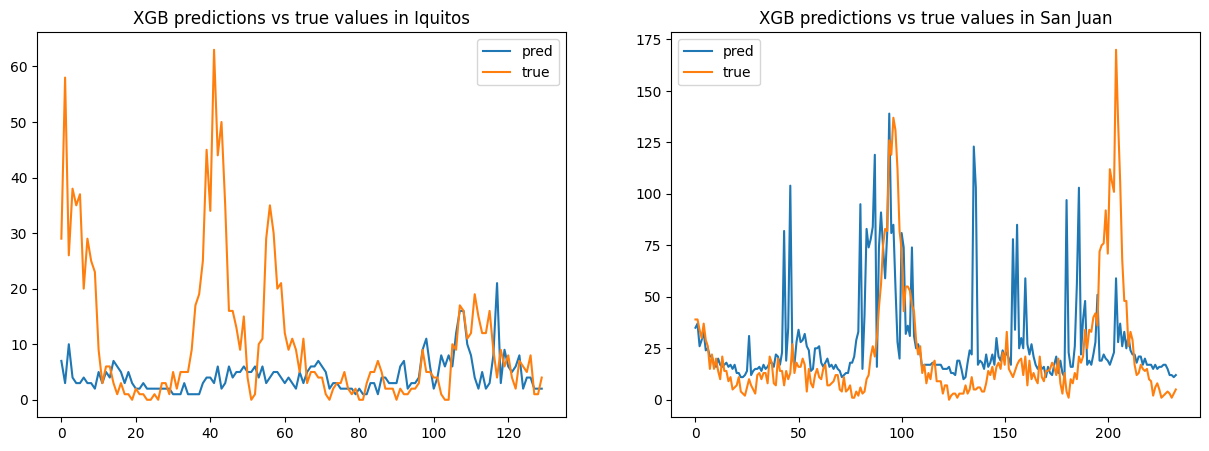

In [181]:
#Plotting predictions vs true values for testing data
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_test_pred, label='pred')
plt.plot(iq_y_test.values, label='true')
plt.legend()
plt.title('XGB predictions vs true values in Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_test_pred, label='pred')
plt.plot(sj_y_test.values, label='true')
plt.legend()
plt.title('XGB predictions vs true values in San Juan')
plt.show;

In [182]:
# Get training and testing metrics to check for overfitting
sj_xgb_metrics = reg_metrics(sj_y_train, sj_train_pred, sj_y_test, sj_test_pred,'San Juan XGB')
iq_xgb_metrics = reg_metrics(iq_y_train, iq_train_pred, iq_y_test, iq_test_pred,'Iquitos XGB')

sj_xgb_metrics, iq_xgb_metrics

(               test_mae  train_mae
 San Juan XGB                      
 0             18.346154  21.293447,
              test_mae  train_mae
 Iquitos XGB                     
 0            8.230769   3.779487)

In [183]:
#Concatenating training and testing predictions and values for visualization
iq_total_pred = np.hstack((iq_train_pred,iq_test_pred))
iq_true_values = np.hstack((iq_y_train.values,iq_y_test.values))

sj_total_pred = np.hstack((sj_train_pred,sj_test_pred))
sj_true_values = np.hstack((sj_y_train.values,sj_y_test.values))

In [185]:
#Using the peak boosting function to scale the predictions
print('San Juan:')
sj_boost = peak_boost(sj_total_pred, 1.5,'pos')
print('Iquitos:')
iq_boost = peak_boost(iq_total_pred, 2, 'max')

San Juan:
Values are doubled over this threshold: 209.6187499999998
Iquitos:
Values are doubled over this threshold: 26.524999999999864


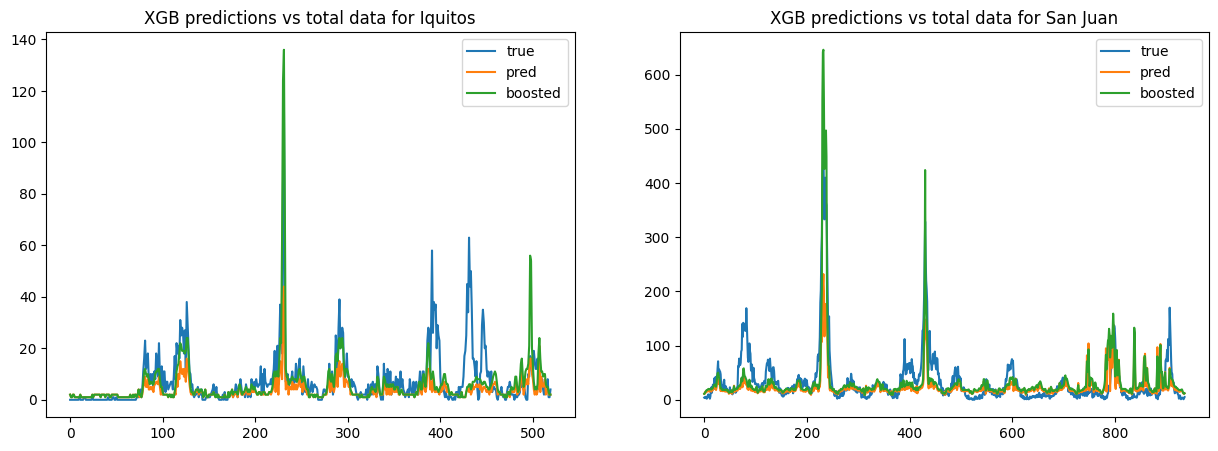

In [186]:
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_true_values, label='true')
plt.plot(iq_total_pred, label='pred')
plt.plot(iq_boost, label='boosted')
plt.legend()
plt.title('XGB predictions vs total data for Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_true_values, label='true')
plt.plot(sj_total_pred, label='pred')
plt.plot(sj_boost, label='boosted')
plt.legend()
plt.title('XGB predictions vs total data for San Juan')
plt.show;

In [188]:
sj_train_boost = peak_boost(sj_train_pred, 1.5, 'pos')
sj_test_boost = peak_boost(sj_test_pred, 1.5, 'pos')
iq_train_boost = peak_boost(iq_train_pred, 2, 'max')
iq_test_boost = peak_boost(iq_test_pred, 2, 'max')

Values are doubled over this threshold: 214.61
Values are doubled over this threshold: 120.88249999999996
Values are doubled over this threshold: 25.270000000000095
Values are doubled over this threshold: 21.709999999999994


In [189]:
#Get metrics after boosting
sj_xgb_metrics = reg_metrics(sj_y_train, sj_train_boost, sj_y_test, sj_test_boost,'San Juan XGB')
iq_xgb_metrics = reg_metrics(iq_y_train, iq_train_boost, iq_y_test, iq_test_boost,'Iquitos XGB')

sj_xgb_metrics, iq_xgb_metrics

(               test_mae  train_mae
 San Juan XGB                      
 0             19.423077  17.930199,
              test_mae  train_mae
 Iquitos XGB                     
 0            8.684615   2.846154)

## Comparing models

In [246]:
sj_rf_metrics,sj_knn_metrics,sj_xgb_metrics,sj_gb_metrics,sj_svr_metrics, iq_rf_metrics,iq_knn_metrics,iq_xgb_metrics,iq_gb_metrics,iq_svr_metrics, 

(              test_mae  train_mae
 San Juan RF                      
 0            16.623932  19.420228,
                test_mae  train_mae
 San Juan KNN                      
 0             19.706197  22.084758,
                test_mae  train_mae
 San Juan XGB                      
 0             19.423077  17.930199,
               test_mae  train_mae
 San Juan GB                      
 0            18.559829  25.064103,
                test_mae  train_mae
 San Juan SVR                      
 0             15.038462  26.554131,
             test_mae  train_mae
 Iquitos RF                     
 0           8.023077   4.238462,
              test_mae  train_mae
 Iquitos KNN                     
 0            8.020192   6.898397,
              test_mae  train_mae
 Iquitos XGB                     
 0            8.684615   2.846154,
             test_mae  train_mae
 Iquitos GB                     
 0           8.238462   3.917949,
              test_mae  train_mae
 Iquitos SVR         

Although the SVR model scored best on the testing data for San Juan and the KNN model scored best for Iquitos, those models combined received a submission score of 27.5938, as there was some underfitting going on. The Random Forest model scored the best upon submission with a score of 23.9712 for the combined mae of both cities.

## Submission

In [247]:
sj_rf_model.fit(sj_X, sj_y)

iq_rf_model.fit(iq_X, iq_y)

print('Training Complete!')

Training Complete!


In [248]:
testing_data = pd.read_csv('../raw_data/dengue_features_test.csv')

In [249]:
sj_test = testing_data[testing_data.city=='sj'].copy()
sj_test = preprocess(sj_test,train=False)
sj_test.shape

(260, 36)

In [250]:
iq_test = testing_data[testing_data.city=='iq'].copy()
iq_test = preprocess(iq_test,train=False)
iq_test.shape

(156, 36)

In [251]:
sj_pred = sj_rf_model.predict(sj_test).astype(int)
iq_pred = iq_rf_model.predict(iq_test).astype(int)
sj_boost = peak_boost(sj_pred, 1.5, 'pos')
iq_boost = peak_boost(iq_pred, 2, 'max')

Values are doubled over this threshold: 89.72875000000019
Values are doubled over this threshold: 16.0


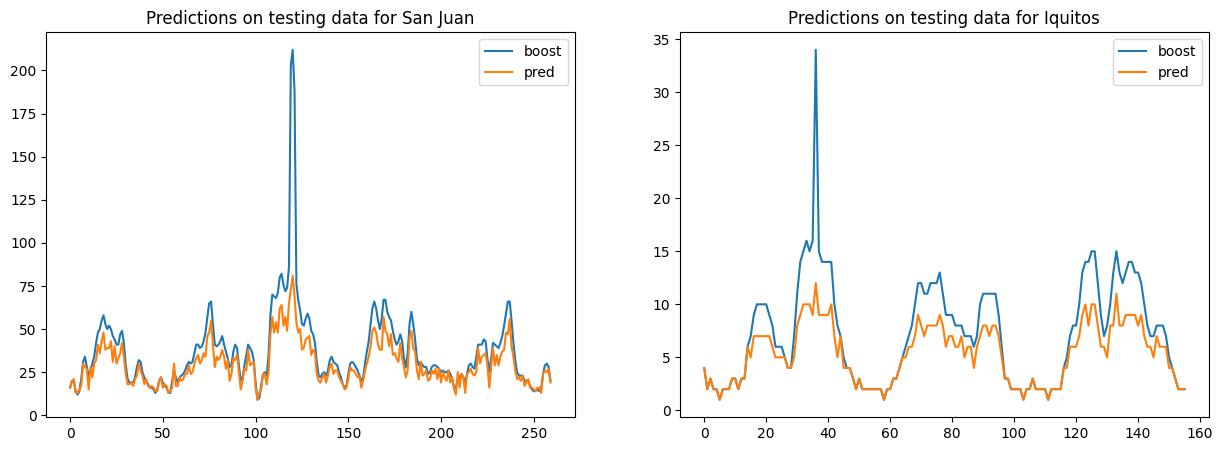

In [252]:
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(sj_boost, label='boost')
plt.plot(sj_pred, label='pred')
plt.legend()
plt.title('Predictions on testing data for San Juan')
plt.show;
plt.subplot(122)
plt.plot(iq_boost, label='boost')
plt.plot(iq_pred, label='pred')
plt.legend()
plt.title('Predictions on testing data for Iquitos')
plt.show;

In [253]:
#Confirm no negative predictions
print(np.min(sj_boost))
print(np.min(iq_boost))

9
1


In [254]:
submission = pd.read_csv('../raw_data/submission_format.csv',
                            index_col=[0, 1, 2])

In [255]:
submission.total_cases = np.concatenate([sj_boost, iq_boost])
submission.to_csv("../submissions/rf_submission.csv")

## Model Evaluation

KNN: MAE of 27.4351 reached upon submission 

SVR: MAE of 26.5601 reached upon submission

RF: MAE of 23.9712 reached upon submission

SVR + KNN: MAE of 27.5938 reached upon submission

GB: MAE of 27.4255 reached upon submission

XGB: MAE of 26.8413 reached upon submission

Our best model, the random forest, ranked 730 out of 12523 submissions, scoring in the top 5.8% of models submitted to the competition.

In [267]:
models = ['Baseline','SVR+KNN', 'SVR','GB','XGB', 'KNN', 'Random Forest']

scores = [35.03609, 27.5938, 27.4351,27.4255,26.8413,26.5601,23.9712]

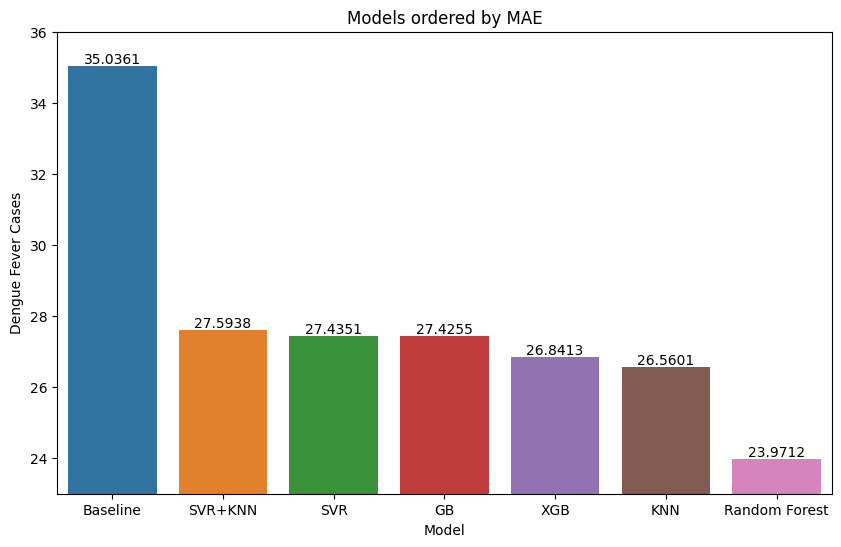

In [272]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x = models, y = scores)
plt.ylim(23, 36)
plt.title('Models ordered by MAE')
plt.ylabel('Dengue Fever Cases')
plt.xlabel('Model');

for i in ax.containers:
    ax.bar_label(i,)